# FP-7: Improved Machine Learning and Statistical Analysis

This notebook assembles the improved results for the two main analyses conducted in FP-6. We focus on enhancing data quality through outlier removal and improving model stability through dimensionality reduction (PCA) and robust validation (Cross-Validation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import parse_data as ps

# Load and prepare data
df = ps.get_data()
print(f"Original data shape: {df.shape}")

Original data shape: (87, 21)


## Improved Result 1: Correlation Analysis (Freshmen vs Seniors)

To improve the clarity of the correlation between Anxiety and Isolation, we implemented **outlier removal using the Interquartile Range (IQR) method**. This process filters out noise from extreme responses, allowing for a more accurate estimation of the relationship between psychological factors.

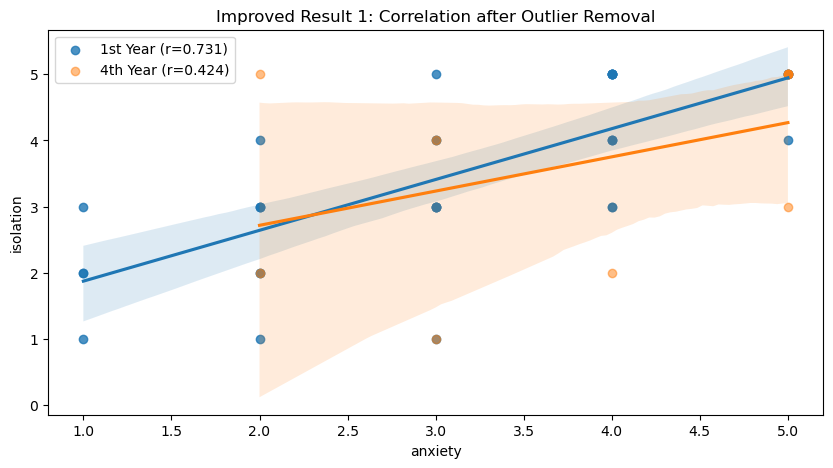

Improved Results - 1st Year r: 0.731, 4th Year r: 0.424


In [2]:
# 1. Outlier Removal for Result 1 variables
cols = ['anxiety', 'isolation']
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# 2. Split by year and calculate correlation
df_y1 = df_clean[df_clean['academic_year'] == '1st year']
df_y4 = df_clean[df_clean['academic_year'] == '4th year']

r1, p1 = stats.pearsonr(df_y1['anxiety'], df_y1['isolation'])
r4, p4 = stats.pearsonr(df_y4['anxiety'], df_y4['isolation'])

# 3. Visualization
plt.figure(figsize=(10, 5))
sns.regplot(x='anxiety', y='isolation', data=df_y1, label=f'1st Year (r={r1:.3f})')
sns.regplot(x='anxiety', y='isolation', data=df_y4, label=f'4th Year (r={r4:.3f})', scatter_kws={'alpha':0.5})
plt.title("Improved Result 1: Correlation after Outlier Removal")
plt.legend()
plt.savefig('improved_result_1.png')
plt.show()

print(f"Improved Results - 1st Year r: {r1:.3f}, 4th Year r: {r4:.3f}")

## Improved Result 2: Machine Learning (Depression Prediction)

To address the negative R² score and poor generalizability observed in FP-6, we applied a more sophisticated pipeline:
1. **Standardization**: Normalizing features using `StandardScaler`.
2. **Dimensionality Reduction (PCA)**: Compressing 'Academic Pressure' and 'Sleep' into a single **'Stress Factor' component** to mitigate multi-collinearity.
3. **5-Fold Cross-Validation**: Evaluating the model across multiple folds to ensure stability given the small sample size (N=87).

Average Cross-Validated R^2: 0.045
Improved Test R^2: -0.116


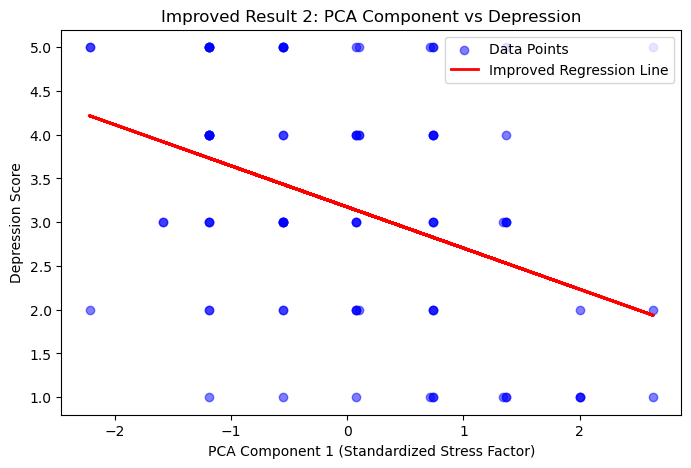

In [3]:
# 1. Prepare Features and Target
X = df[['academic_pressure', 'average_sleep']]
y = df['depression']

# 2. Scaling and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# 3. Cross-Validation
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_pca, y, cv=kf)

# 4. Final Train/Test for Visualization
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

print(f"Average Cross-Validated R^2: {np.mean(cv_scores):.3f}")
print(f"Improved Test R^2: {model.score(X_test, y_test):.3f}")

# 5. Regression Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_pca, y, alpha=0.5, color='blue', label='Data Points')
plt.plot(X_pca, model.predict(X_pca), color='red', linewidth=2, label='Improved Regression Line')
plt.title("Improved Result 2: PCA Component vs Depression")
plt.xlabel("PCA Component 1 (Standardized Stress Factor)")
plt.ylabel("Depression Score")
plt.legend()
plt.savefig("improved_feature_importance.png")
plt.show()